Rules of the file : 
* If dataset works better than the previous one, keep that one. Else, use the previous one

# Base kit and first functions/columns added - name of the file : data

In [75]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns

### Loading the data with pandas

First, download the data files from Kaggle, and put them to into the data folder.


Data is stored in [Parquet format](https://parquet.apache.org/), an efficient columnar data format. We can load the train set with pandas,

In [74]:
data = pd.read_parquet(Path("data") / "train.parquet")
data.head()

,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,coordinates,counter_technical_id,latitude,longitude,log_bike_count
48321,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 02:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.000000
48324,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,1.0,2020-09-01 03:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.693147
48327,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 04:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.000000
48330,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,4.0,2020-09-01 15:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,1.609438
48333,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,9.0,2020-09-01 18:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,2.302585


We can check general information about different columns:

In [ ]:
data.info()

and in particular the number of unique entries in each column,

In [ ]:
data.nunique(axis=0)

We have a 30 counting sites where sometimes multiple counters are installed per location.  Let's look at the most frequented stations:

In [ ]:
(
    data.groupby(["site_name", "counter_name"])["bike_count"].sum()
    .sort_values(ascending=False)
    .head(10)
    .to_frame()
)

### Feature extraction

To account for the temporal aspects of the data, we cannot input the `date` field directly into the model. Instead we extract the features on different time-scales from the `date` field:

In [14]:
def _encode_dates(X):
    X = X.copy()  # modify a copy of X
    # Encode the date information from the DateOfDeparture columns
    X["year"] = X["date"].dt.year
    X["month"] = X["date"].dt.month
    X["day"] = X["date"].dt.day
    X["weekday"] = X["date"].dt.weekday
    X["hour"] = X["date"].dt.hour

    # Finally we can drop the original columns from the dataframe
    return X.drop(columns=["date"])

In [ ]:
data["date"].head()

In [ ]:
_encode_dates(data[["date"]].head())

To use this function with scikit-learn estimators we wrap it with [FunctionTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.FunctionTransformer.html):

In [ ]:
from sklearn.preprocessing import FunctionTransformer

date_encoder = FunctionTransformer(_encode_dates, validate=False)
sample_encoded = date_encoder.fit_transform(data[["date"]]).head()
sample_encoded

Since it is unlikely that, for instance, that `hour` is linearly correlated with the target variable, we would need to additionally encode categorical features for linear models. This is classically done with [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html), though other encoding strategies exist.

In [ ]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(sparse_output=False)

enc.fit_transform(sample_encoded[["hour"]])

In [ ]:
pip install holidays

In [20]:
import holidays
fr_holidays = holidays.France(years=[2020,2021])

def _encode_dates(X):
    X = X.copy()  # modify a copy of X
    # Encode the date information from the Date columns
    X["year"] = X["date"].dt.year
    X["month"] = X["date"].dt.month
    X["day"] = X["date"].dt.day
    X["weekday"] = X["date"].dt.weekday
    X["hour"] = X["date"].dt.hour
    X['bankholidays'] = X['date'].isin(fr_holidays).astype(int)
    X['weekend'] = X['weekday'].isin([6,7]).astype(int)
    X['night'] = X['hour'].isin([20, 21, 22, 23, 24, 1, 2, 3, 4, 5, 6]).astype(int)
    X['morning'] = X['hour'].isin([6, 7, 8, 9, 10, 11, 12]).astype(int)
    X['midday'] = X['hour'].isin([12, 13, 14]).astype(int)
    X['evening'] = X['hour'].isin([14, 15, 16, 17, 18, 19, 20]).astype(int)

    # Finally we can drop the original columns from the dataframe
    return X.drop(columns=["date"])

### Baseline mean prediction

#### Ridge

Baseline mean prediction.
Train set, RMSE=1.67
Test set, RMSE=1.44

#### Ridge with StandardScaler

# Getting rid of some data - name of the file : data_bike_rid

In [76]:
data.head()

,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,coordinates,counter_technical_id,latitude,longitude,log_bike_count
48321,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 02:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.000000
48324,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,1.0,2020-09-01 03:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.693147
48327,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 04:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.000000
48330,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,4.0,2020-09-01 15:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,1.609438
48333,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,9.0,2020-09-01 18:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,2.302585


In [77]:
target_columns = ["bike_count", "log_bike_count"]
numerical_columns = ['latitude', 'longitude']
categorical_columns = ['counter_name', 'site_name', 'counter_technical_id']
date_columns = ['date', 'counter_installation_date']
all_columns = numerical_columns + categorical_columns + date_columns + target_columns

data_bike_rid = data[all_columns]
# cosmetic changes

Baseline mean prediction.
Train set, RMSE=1.67
Test set, RMSE=1.44

# Adding the arrondissement - name of the file : data_bike_arr

In [ ]:
pip install geopandas

In [ ]:
data_bike_arr = data.copy()

In [ ]:
import geopandas as gpd
from shapely.geometry import Point

# Load the GeoJSON file containing Paris arrondissements
arrondissements = gpd.read_file(Path("external_data") / "arrondissements.geojson")

# Ensure arrondissements GeoDataFrame has a compatible CRS
arrondissements = arrondissements.to_crs(epsg=4326)

# Assuming 'data' is your original dataset with latitude and longitude columns
data_bike_arr['geometry'] = gpd.points_from_xy(data_bike_arr['longitude'], data_bike_arr['latitude'], crs="EPSG:4326")

# Convert the DataFrame to a GeoDataFrame
data_gdf = gpd.GeoDataFrame(data_bike_arr, geometry='geometry')

# Perform the spatial join
result = gpd.sjoin(data_gdf, arrondissements, how="left", predicate="within")


# Access the relevant arrondissement column
data_bike_arr['arrondissement'] = result[['l_ar']]  # Replace 'nom' with the arrondissement column name

data_bike_arr.head()



In [18]:
# Getting rid of Geometry

data_bike_arr = data_bike_arr.drop(columns=['geometry'])

In [ ]:
data_bike_arr['arrondissement'].hist(figsize=(12, 6))
plt.xticks(rotation = 45); # Let's have a look at feature we added

We notice that : 
* The arrondissements with the most bikes are the 11th, the 12th, the 13th, the 14th, the 19th and the 20th
* In the the 10th, there is no bikes, and much fewer than elswehere in the 7th, 8th, 9th 

Baseline mean prediction.
Train set, RMSE=1.67
Test set, RMSE=1.44

# Adding the arrondissement after getting rid of extra data - name of the file : data_bike_arr_rid

In [28]:
data_bike_arr_rid = data_bike_rid.copy()

In [ ]:
import geopandas as gpd
from shapely.geometry import Point

# Load the GeoJSON file containing Paris arrondissements
arrondissements = gpd.read_file(Path("external_data") / "arrondissements.geojson")

# Ensure arrondissements GeoDataFrame has a compatible CRS
arrondissements = arrondissements.to_crs(epsg=4326)

# Assuming 'data' is your original dataset with latitude and longitude columns
data_bike_arr_rid['geometry'] = gpd.points_from_xy(data_bike_arr_rid['longitude'], data_bike_arr_rid['latitude'], crs="EPSG:4326")

# Convert the DataFrame to a GeoDataFrame
data_gdf = gpd.GeoDataFrame(data_bike_arr_rid, geometry='geometry')

# Perform the spatial join
result = gpd.sjoin(data_gdf, arrondissements, how="left", predicate="within")


# Access the relevant arrondissement column
data_bike_arr_rid['arrondissement'] = result[['l_ar']]  # Replace 'nom' with the arrondissement column name

data_bike_arr_rid.head()


In [22]:
data_bike_arr_rid= data_bike_arr_rid.drop(columns='geometry')

Baseline mean prediction.
Train set, RMSE=1.67
Test set, RMSE=1.44

# Adding the external meteorological data : data_meteo

In [78]:
import pandas as pd
external_data = pd.read_csv("data/external_data.csv")


In [79]:
# Liste des noms actuels des colonnes
old_column_names = [
    "counter_id", "counter_name", "site_id", "site_name", "bike_count",
    "date", "counter_installation_date", "coordinates",
    "counter_technical_id", "latitude", "longitude", "log_bike_count",
    "numer_sta", "pmer", "tend", "cod_tend", "dd", "ff", "t", "td", "u",
    "vv", "ww", "w1", "w2", "n", "nbas", "hbas", "cl", "cm", "ch", "pres",
    "tend24", "tn12", "tx12", "tminsol", "raf10", "rafper", "per",
    "etat_sol", "ht_neige", "ssfrai", "perssfrai", "rr1", "rr3", "rr6",
    "rr12", "rr24", "nnuage1", "ctype1", "hnuage1", "nnuage2", "ctype2",
    "hnuage2", "nnuage3", "ctype3", "hnuage3", "nnuage4", "ctype4",
    "hnuage4"
]

# Dictionnaire des correspondances
column_mapping = {
    "numer_sta": "ID OMM station",
    "date": "date",
    "pmer": "Pression au niveau mer",
    "tend": "Variation de pression en 3 heures",
    "cod_tend": "Type de tendance barométrique",
    "dd": "Direction du vent moyen 10 mn",
    "ff": "Vitesse du vent moyen 10 mn",
    "t": "Température",
    "td": "Point de rosée",
    "u": "Humidité",
    "vv": "Visibilité horizontale",
    "ww": "Temps présent",
    "w1": "Temps passé 1",
    "w2": "Temps passé 2",
    "n": "Nebulosité totale",
    "nbas": "Nébulosité des nuages de l’étage inférieur",
    "hbas": "Hauteur de la base des nuages de l’étage inférieur",
    "cl": "Type des nuages de l’étage inférieur",
    "cm": "Type des nuages de l’étage moyen",
    "ch": "Type des nuages de l’étage supérieur",
    "pres": "Pression station",
    "tend24": "Variation de pression en 24 heures",
    "tn12": "Température minimale sur 12 heures",
    "tx12": "Température maximale sur 12 heures",
    "tminsol": "Température minimale du sol sur 12 heures",
    "raf10": "Rafale sur les 10 dernières minutes",
    "rafper": "Rafales sur une période",
    "per": "Periode de mesure de la rafale",
    "etat_sol": "Etat du sol",
    "ht_neige": "Hauteur totale de la couche de neige, glace, autre au sol",
    "ssfrai": "Hauteur de la neige fraîche",
    "perssfrai": "Periode de mesure de la neige fraiche",
    "rr1": "Précipitations dans la dernière heure",
    "rr3": "Précipitations dans les 3 dernières heures",
    "rr6": "Précipitations dans les 6 dernières heures",
    "rr12": "Précipitations dans les 12 dernières heures",
    "rr24": "Précipitations dans les 24 dernières heures",
    "nnuage1": "Nébulosité couche nuageuse 1",
    "ctype1": "Type nuage 1",
    "hnuage1": "Hauteur de base 1",
    "nnuage2": "Nébulosité couche nuageuse 2",
    "ctype2": "Type nuage 2",
    "hnuage2": "Hauteur de base 2",
    "nnuage3": "Nébulosité couche nuageuse 3",
    "ctype3": "Type nuage 3",
    "hnuage3": "Hauteur de base 3",
    "nnuage4": "Nébulosité couche nuageuse 4",
    "ctype4": "Type nuage 4",
    "hnuage4": "Hauteur de base 4",
    "coordinates": "Coordonnees",
    "latitude": "Latitude",
    "longitude": "Longitude"
}

# Filtrer les colonnes à renommer
columns_to_rename = {col: column_mapping[col] for col in old_column_names if col in column_mapping}

# Renommer les colonnes dans le DataFrame
external_data.rename(columns=columns_to_rename, inplace=True)

# Afficher les nouvelles colonnes
print(external_data.columns)


Index(['ID OMM station', 'date', 'Pression au niveau mer',
       'Variation de pression en 3 heures', 'Type de tendance barométrique',
       'Direction du vent moyen 10 mn', 'Vitesse du vent moyen 10 mn',
       'Température', 'Point de rosée', 'Humidité', 'Visibilité horizontale',
       'Temps présent', 'Temps passé 1', 'Temps passé 2', 'Nebulosité totale',
       'Nébulosité des nuages de l’étage inférieur',
       'Hauteur de la base des nuages de l’étage inférieur',
       'Type des nuages de l’étage inférieur',
       'Type des nuages de l’étage moyen',
       'Type des nuages de l’étage supérieur', 'Pression station', 'niv_bar',
       'geop', 'Variation de pression en 24 heures',
       'Température minimale sur 12 heures', 'tn24',
       'Température maximale sur 12 heures', 'tx24',
       'Température minimale du sol sur 12 heures', 'sw', 'tw',
       'Rafale sur les 10 dernières minutes', 'Rafales sur une période',
       'Periode de mesure de la rafale', 'Etat du sol',
  

In [80]:
# Liste des colonnes à extraire
columns_to_add = [
    "Température", 
    "Direction du vent moyen 10 mn", 
    "Vitesse du vent moyen 10 mn", 
    "Humidité", 
    "Température minimale sur 12 heures", 
    "Température maximale sur 12 heures", 
    "Température minimale du sol sur 12 heures", 
    "Rafale sur les 10 dernières minutes", 
    "Rafales sur une période", 
    "Periode de mesure de la rafale", 
    "Etat du sol", 
    "Hauteur totale de la couche de neige, glace, autre au sol", 
    "Précipitations dans la dernière heure", 
    "Précipitations dans les 3 dernières heures", 
    "Précipitations dans les 6 dernières heures", 
    "Précipitations dans les 12 dernières heures", 
    "Précipitations dans les 24 dernières heures", 
    "date"
]

# Créer un nouveau DataFrame avec les colonnes sélectionnées
data_meteo_to_add = external_data[columns_to_add]

# Vérification rapide
data_meteo_to_add.head()


,Température,Direction du vent moyen 10 mn,Vitesse du vent moyen 10 mn,Humidité,Température minimale sur 12 heures,Température maximale sur 12 heures,Température minimale du sol sur 12 heures,Rafale sur les 10 dernières minutes,Rafales sur une période,Periode de mesure de la rafale,Etat du sol,"Hauteur totale de la couche de neige, glace, autre au sol",Précipitations dans la dernière heure,Précipitations dans les 3 dernières heures,Précipitations dans les 6 dernières heures,Précipitations dans les 12 dernières heures,Précipitations dans les 24 dernières heures,date
0,272.75,270,1.8,96,NaN,NaN,NaN,2.5,2.5,-10,1.0,0.00,0.0,0.0,0.0,0.0,2.0,2021-01-01 00:00:00
1,271.25,300,1.7,98,NaN,NaN,NaN,2.2,2.2,-10,1.0,0.00,0.0,0.0,0.0,0.0,1.2,2021-01-01 03:00:00
2,271.95,290,2.6,98,270.75,275.25,NaN,3.2,3.2,-10,1.0,0.00,0.0,0.0,0.0,0.0,1.0,2021-01-01 06:00:00
3,272.45,280,1.7,97,NaN,NaN,NaN,2.3,2.3,-10,13.0,0.01,0.0,0.2,0.2,0.2,0.2,2021-01-01 09:00:00
4,276.95,50,1.0,82,NaN,NaN,NaN,2.5,4.4,-10,11.0,-0.01,0.0,0.0,0.2,0.2,0.2,2021-01-01 12:00:00


In [81]:
# Ajuster le nombre maximum de colonnes visible
pd.set_option('display.max_columns', None)

# Ajuster le nombre maximum de lignes visibles
pd.set_option('display.max_rows', None)

data_meteo = data_bike_rid.copy()
data_meteo['date'] = pd.to_datetime(data_meteo['date'])
data_meteo_to_add['date'] = pd.to_datetime(data_meteo_to_add['date'])

# Merging the two datas
data_meteo = pd.merge(data_meteo, data_meteo_to_add, on='date', how='inner')

data_meteo.head()


/var/folders/rl/bm5wfk4s06n9k8gfktpvjdhh0000gn/T/ipykernel_51132/4251580608.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_meteo_to_add['date'] = pd.to_datetime(data_meteo_to_add['date'])


,latitude,longitude,counter_name,site_name,counter_technical_id,date,counter_installation_date,bike_count,log_bike_count,Température,Direction du vent moyen 10 mn,Vitesse du vent moyen 10 mn,Humidité,Température minimale sur 12 heures,Température maximale sur 12 heures,Température minimale du sol sur 12 heures,Rafale sur les 10 dernières minutes,Rafales sur une période,Periode de mesure de la rafale,Etat du sol,"Hauteur totale de la couche de neige, glace, autre au sol",Précipitations dans la dernière heure,Précipitations dans les 3 dernières heures,Précipitations dans les 6 dernières heures,Précipitations dans les 12 dernières heures,Précipitations dans les 24 dernières heures
0,48.846028,2.375429,28 boulevard Diderot E-O,28 boulevard Diderot,Y2H15027244,2020-09-01 03:00:00,2013-01-18,1.0,0.693147,283.95,290,1.1,88,NaN,NaN,NaN,1.5,1.5,-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,48.846028,2.375429,28 boulevard Diderot E-O,28 boulevard Diderot,Y2H15027244,2020-09-01 15:00:00,2013-01-18,4.0,1.609438,293.65,40,4.0,41,NaN,NaN,NaN,7.5,7.5,-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,48.846028,2.375429,28 boulevard Diderot E-O,28 boulevard Diderot,Y2H15027244,2020-09-01 18:00:00,2013-01-18,9.0,2.302585,292.15,20,3.0,47,284.35,295.45,NaN,6.5,6.5,-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,48.846028,2.375429,28 boulevard Diderot E-O,28 boulevard Diderot,Y2H15027244,2020-09-02 18:00:00,2013-01-18,7.0,2.079442,292.75,330,2.4,44,284.45,295.85,NaN,3.7,5.1,-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,48.846028,2.375429,28 boulevard Diderot E-O,28 boulevard Diderot,Y2H15027244,2020-09-03 15:00:00,2013-01-18,12.0,2.564949,300.35,250,4.6,36,NaN,NaN,NaN,7.7,7.9,-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [82]:
# Identifier les colonnes avec uniquement des valeurs nulles
colonnes_entièrement_nulles = data_meteo.columns[data_meteo.isna().all()]

# Afficher les colonnes complètement nulles
print("Colonnes avec uniquement des valeurs nulles :")
print(colonnes_entièrement_nulles)


Colonnes avec uniquement des valeurs nulles :
Index([], dtype='object')


In [83]:
# Supprimer les colonnes avec uniquement des valeurs nulles
data_meteo = data_meteo.dropna(axis=1, how='all')

# Vérifier les colonnes restantes
print("Colonnes restantes après suppression :")
print(data_meteo.columns)


Colonnes restantes après suppression :
Index(['latitude', 'longitude', 'counter_name', 'site_name',
       'counter_technical_id', 'date', 'counter_installation_date',
       'bike_count', 'log_bike_count', 'Température',
       'Direction du vent moyen 10 mn', 'Vitesse du vent moyen 10 mn',
       'Humidité', 'Température minimale sur 12 heures',
       'Température maximale sur 12 heures',
       'Température minimale du sol sur 12 heures',
       'Rafale sur les 10 dernières minutes', 'Rafales sur une période',
       'Periode de mesure de la rafale', 'Etat du sol',
       'Hauteur totale de la couche de neige, glace, autre au sol',
       'Précipitations dans la dernière heure',
       'Précipitations dans les 3 dernières heures',
       'Précipitations dans les 6 dernières heures',
       'Précipitations dans les 12 dernières heures',
       'Précipitations dans les 24 dernières heures'],
      dtype='object')


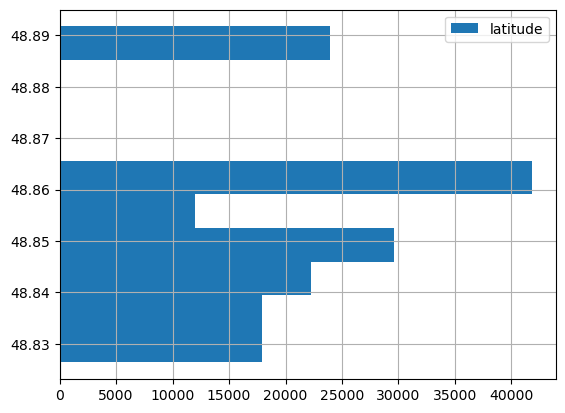

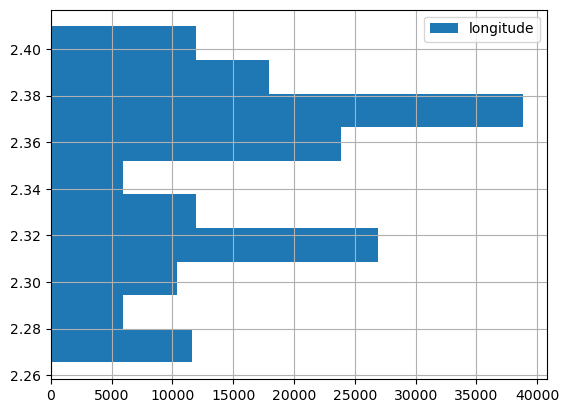

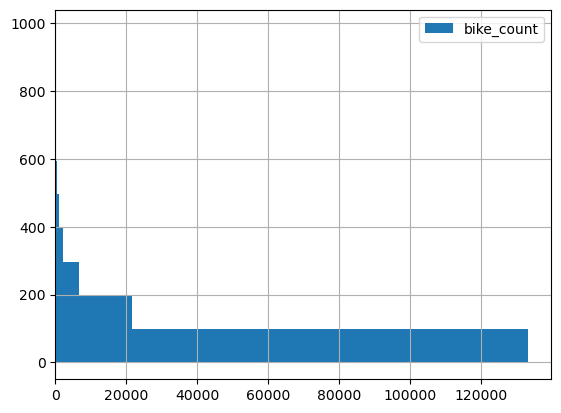

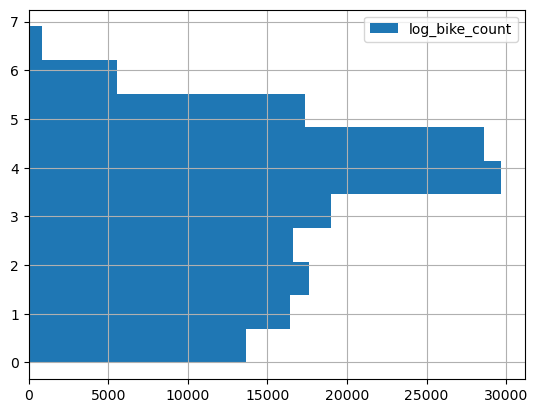

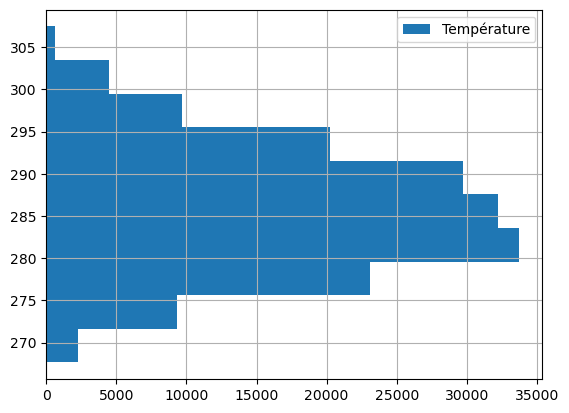

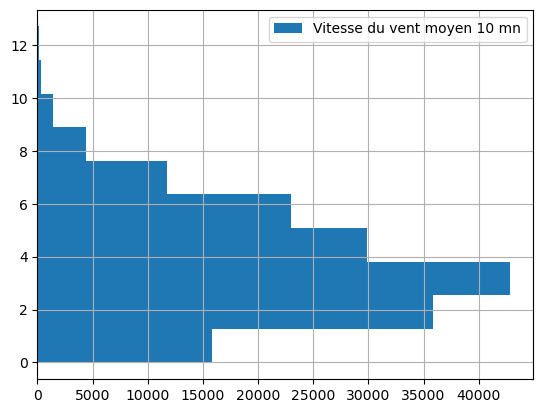

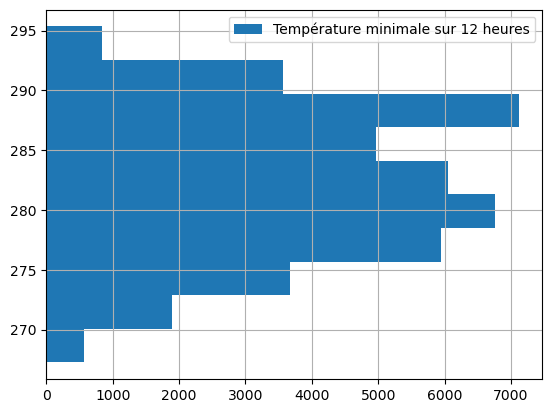

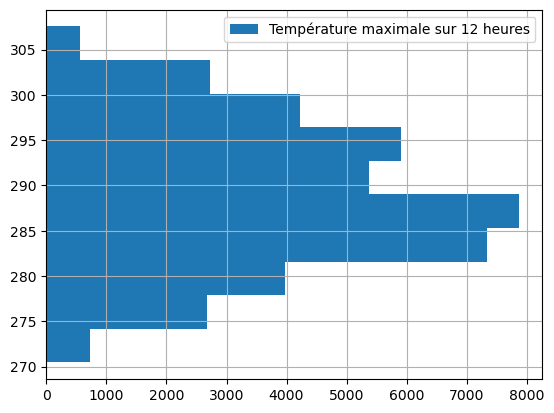

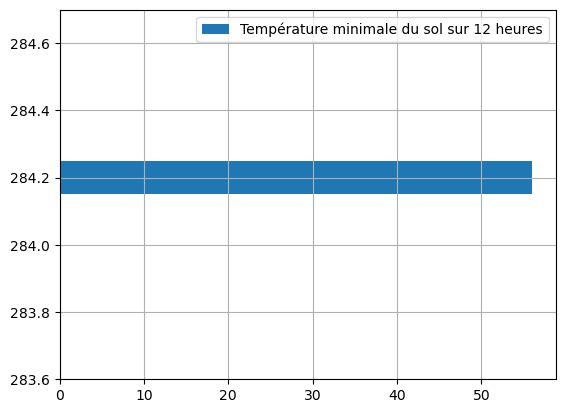

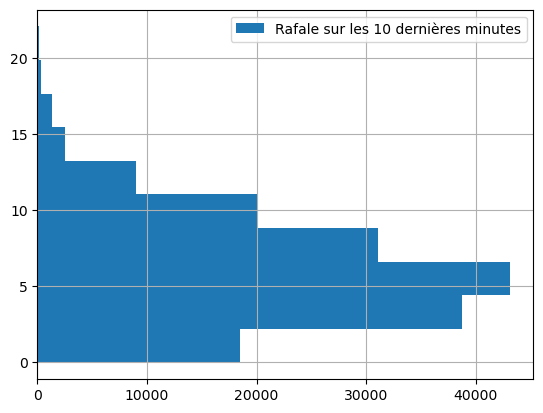

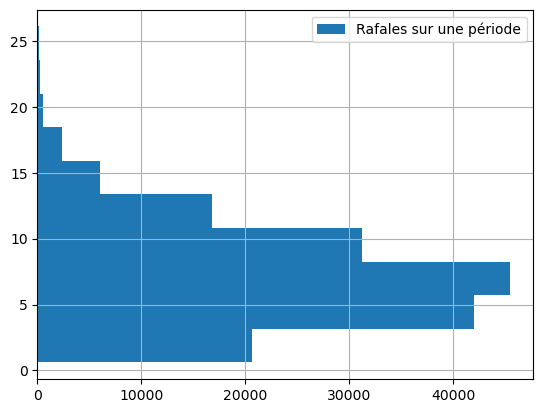

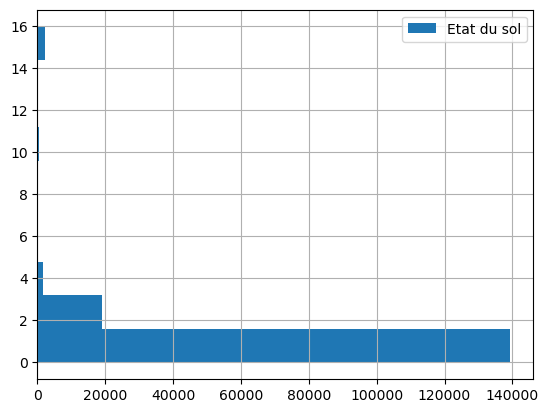

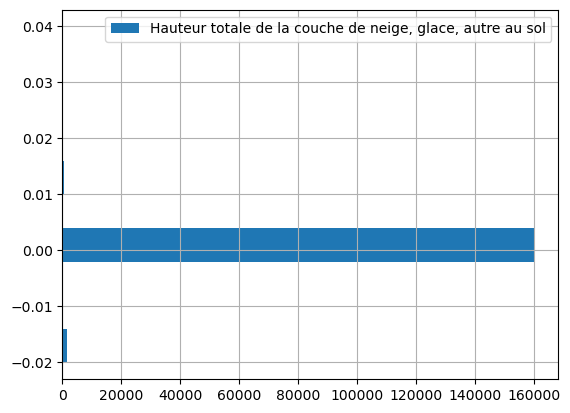

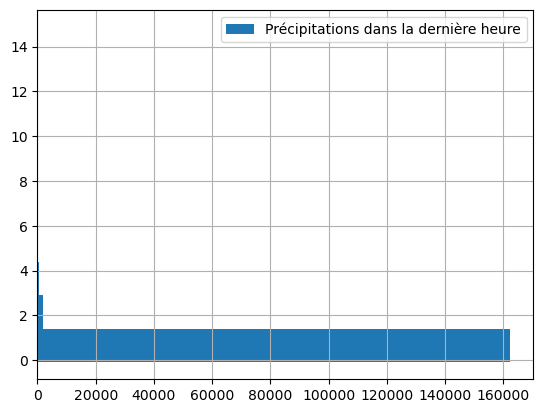

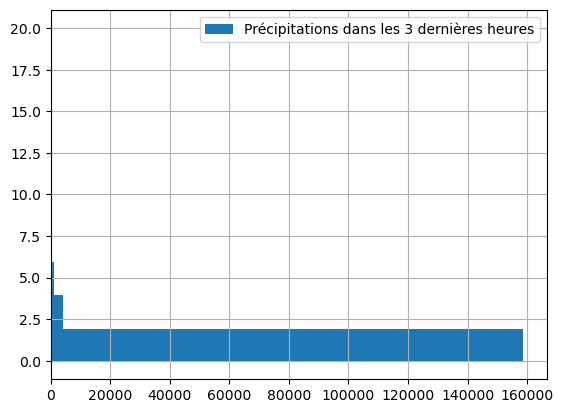

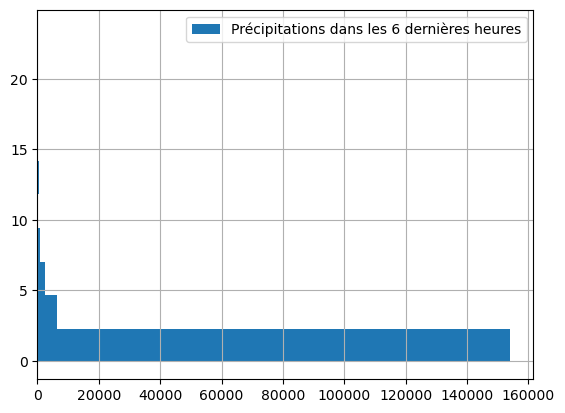

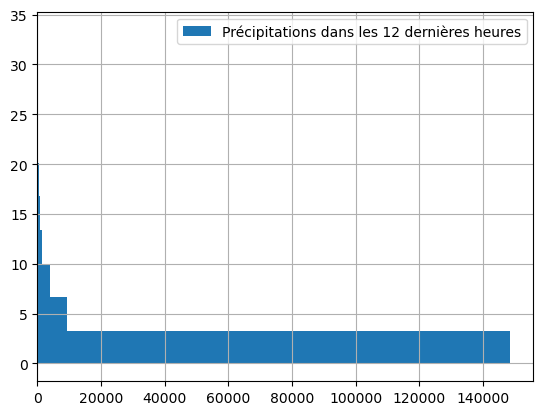

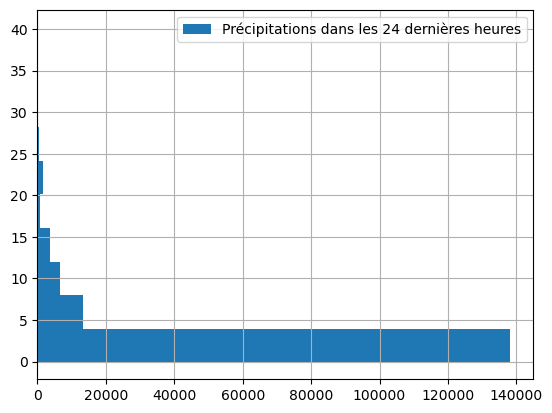

In [84]:
for feature in data_meteo.select_dtypes(include=["float"]).columns:
    data_meteo[feature].hist(legend=True, orientation="horizontal")
    plt.show()

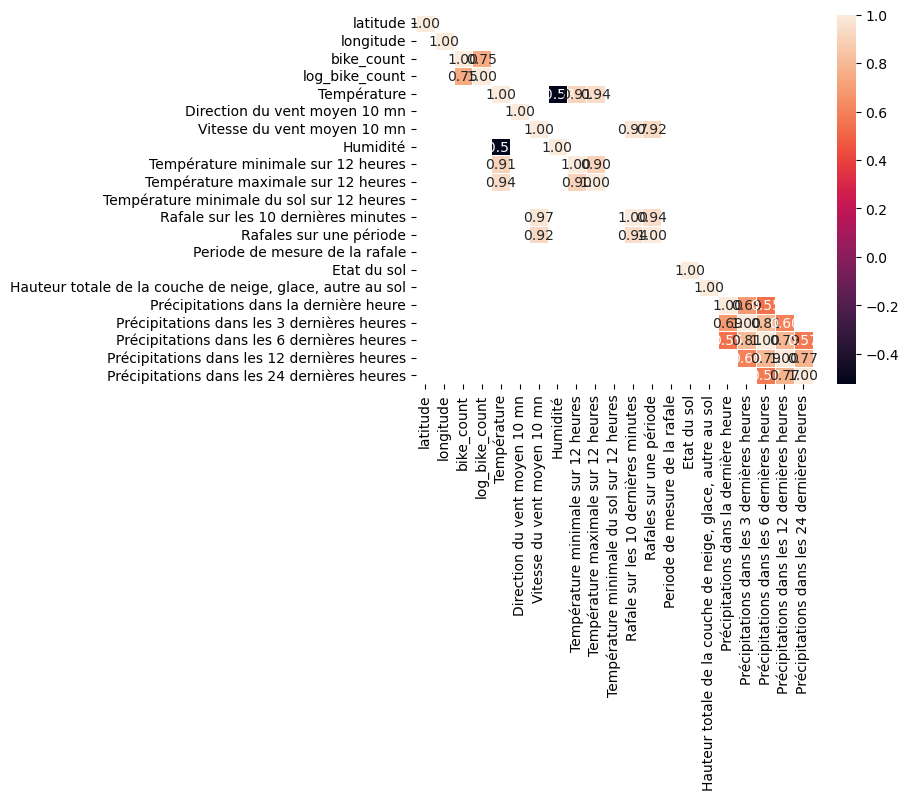

In [85]:
corr_matrix = data_meteo.select_dtypes(include=['int64', 'float64']).corr()
strong_corrs = corr_matrix[(corr_matrix >= 0.5) | (corr_matrix <= -0.5)]
sns.heatmap(strong_corrs, annot=True, fmt=".2f", linewidths=.5)

# Supprimer les colonnes très corrélées
threshold = 0.8
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)]
data_meteo = data_meteo.drop(columns=to_drop)


In [86]:
data_meteo.head()

,latitude,longitude,counter_name,site_name,counter_technical_id,date,counter_installation_date,bike_count,log_bike_count,Température,Direction du vent moyen 10 mn,Vitesse du vent moyen 10 mn,Humidité,Température minimale du sol sur 12 heures,Periode de mesure de la rafale,Etat du sol,"Hauteur totale de la couche de neige, glace, autre au sol",Précipitations dans la dernière heure,Précipitations dans les 3 dernières heures,Précipitations dans les 12 dernières heures,Précipitations dans les 24 dernières heures
0,48.846028,2.375429,28 boulevard Diderot E-O,28 boulevard Diderot,Y2H15027244,2020-09-01 03:00:00,2013-01-18,1.0,0.693147,283.95,290,1.1,88,NaN,-10,0.0,0.0,0.0,0.0,0.0,0.0
1,48.846028,2.375429,28 boulevard Diderot E-O,28 boulevard Diderot,Y2H15027244,2020-09-01 15:00:00,2013-01-18,4.0,1.609438,293.65,40,4.0,41,NaN,-10,0.0,0.0,0.0,0.0,0.0,0.0
2,48.846028,2.375429,28 boulevard Diderot E-O,28 boulevard Diderot,Y2H15027244,2020-09-01 18:00:00,2013-01-18,9.0,2.302585,292.15,20,3.0,47,NaN,-10,0.0,0.0,0.0,0.0,0.0,0.0
3,48.846028,2.375429,28 boulevard Diderot E-O,28 boulevard Diderot,Y2H15027244,2020-09-02 18:00:00,2013-01-18,7.0,2.079442,292.75,330,2.4,44,NaN,-10,0.0,0.0,0.0,0.0,0.0,0.0
4,48.846028,2.375429,28 boulevard Diderot E-O,28 boulevard Diderot,Y2H15027244,2020-09-03 15:00:00,2013-01-18,12.0,2.564949,300.35,250,4.6,36,NaN,-10,0.0,0.0,0.0,0.0,0.0,0.0


In [87]:
# Imputer avec les valeurs précédentes
data_meteo.fillna(method='ffill', inplace=True)
data_meteo.head()

/var/folders/rl/bm5wfk4s06n9k8gfktpvjdhh0000gn/T/ipykernel_51132/3489617446.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_meteo.fillna(method='ffill', inplace=True)


,latitude,longitude,counter_name,site_name,counter_technical_id,date,counter_installation_date,bike_count,log_bike_count,Température,Direction du vent moyen 10 mn,Vitesse du vent moyen 10 mn,Humidité,Température minimale du sol sur 12 heures,Periode de mesure de la rafale,Etat du sol,"Hauteur totale de la couche de neige, glace, autre au sol",Précipitations dans la dernière heure,Précipitations dans les 3 dernières heures,Précipitations dans les 12 dernières heures,Précipitations dans les 24 dernières heures
0,48.846028,2.375429,28 boulevard Diderot E-O,28 boulevard Diderot,Y2H15027244,2020-09-01 03:00:00,2013-01-18,1.0,0.693147,283.95,290,1.1,88,NaN,-10,0.0,0.0,0.0,0.0,0.0,0.0
1,48.846028,2.375429,28 boulevard Diderot E-O,28 boulevard Diderot,Y2H15027244,2020-09-01 15:00:00,2013-01-18,4.0,1.609438,293.65,40,4.0,41,NaN,-10,0.0,0.0,0.0,0.0,0.0,0.0
2,48.846028,2.375429,28 boulevard Diderot E-O,28 boulevard Diderot,Y2H15027244,2020-09-01 18:00:00,2013-01-18,9.0,2.302585,292.15,20,3.0,47,NaN,-10,0.0,0.0,0.0,0.0,0.0,0.0
3,48.846028,2.375429,28 boulevard Diderot E-O,28 boulevard Diderot,Y2H15027244,2020-09-02 18:00:00,2013-01-18,7.0,2.079442,292.75,330,2.4,44,NaN,-10,0.0,0.0,0.0,0.0,0.0,0.0
4,48.846028,2.375429,28 boulevard Diderot E-O,28 boulevard Diderot,Y2H15027244,2020-09-03 15:00:00,2013-01-18,12.0,2.564949,300.35,250,4.6,36,NaN,-10,0.0,0.0,0.0,0.0,0.0,0.0


In [88]:
# Vérifier le nombre de NaN dans la colonne spécifique
nan_count = data_meteo['Température minimale du sol sur 12 heures'].isna().sum()
print(f"Nombre de NaN dans 'Température minimale du sol sur 12 heures' : {nan_count}")

# Vérifier le pourcentage de NaN dans cette colonne
nan_percentage = data_meteo['Température minimale du sol sur 12 heures'].isna().mean() * 100
print(f"Pourcentage de NaN dans 'Température minimale du sol sur 12 heures' : {nan_percentage:.2f}%")


Nombre de NaN dans 'Température minimale du sol sur 12 heures' : 2819
Pourcentage de NaN dans 'Température minimale du sol sur 12 heures' : 1.70%


In [89]:
# Compter le nombre de NaN dans chaque colonne
data_meteo.isna().sum()

latitude                                                        0
longitude                                                       0
counter_name                                                    0
site_name                                                       0
counter_technical_id                                            0
date                                                            0
counter_installation_date                                       0
bike_count                                                      0
log_bike_count                                                  0
Température                                                     0
Direction du vent moyen 10 mn                                   0
Vitesse du vent moyen 10 mn                                     0
Humidité                                                        0
Température minimale du sol sur 12 heures                    2819
Periode de mesure de la rafale                                  0
Etat du so

In [90]:
data_meteo = data_meteo.dropna(axis=0)
# Compter le nombre de NaN dans chaque colonne
data_meteo.isna().sum()

latitude                                                     0
longitude                                                    0
counter_name                                                 0
site_name                                                    0
counter_technical_id                                         0
date                                                         0
counter_installation_date                                    0
bike_count                                                   0
log_bike_count                                               0
Température                                                  0
Direction du vent moyen 10 mn                                0
Vitesse du vent moyen 10 mn                                  0
Humidité                                                     0
Température minimale du sol sur 12 heures                    0
Periode de mesure de la rafale                               0
Etat du sol                                            

# Ridge (here because of bug in Ridge file)

In [91]:
import holidays
fr_holidays = holidays.France(years=[2020,2021])

def _encode_dates(X):
    X = X.copy()  # modify a copy of X
    # Encode the date information from the Date columns
    X["year"] = X["date"].dt.year
    X["month"] = X["date"].dt.month
    X["day"] = X["date"].dt.day
    X["weekday"] = X["date"].dt.weekday
    X["hour"] = X["date"].dt.hour
    X['bankholidays'] = X['date'].isin(fr_holidays).astype(int)
    X['weekend'] = X['weekday'].isin([6,7]).astype(int)
    X['night'] = X['hour'].isin([20, 21, 22, 23, 24, 1, 2, 3, 4, 5, 6]).astype(int)
    X['morning'] = X['hour'].isin([6, 7, 8, 9, 10, 11, 12]).astype(int)
    X['midday'] = X['hour'].isin([12, 13, 14]).astype(int)
    X['evening'] = X['hour'].isin([14, 15, 16, 17, 18, 19, 20]).astype(int)

    # Finally we can drop the original columns from the dataframe
    return X.drop(columns=["date"])

In [92]:
# Here we cheat a bit and use the function located in utils in order to replace data with the processed data we want from feature_engineering
_target_column_name = "log_bike_count"
def get_train_data(data):
    data = data.sort_values(["date", "counter_name"])
    y_array = data[_target_column_name].values
    X_df = data.drop([_target_column_name, "bike_count"], axis=1)
    return X_df, y_array

In [108]:
X, y = get_train_data(data_meteo) # to replace with the processed data from feature_engineering we want to use

In [109]:
def train_test_split_temporal(X, y, delta_threshold="30 days"):

    cutoff_date = X["date"].max() - pd.Timedelta(delta_threshold)
    mask = (X["date"] <= cutoff_date)
    X_train, X_valid = X.loc[mask], X.loc[~mask]
    y_train, y_valid = y[mask], y[~mask]

    return X_train, y_train, X_valid, y_valid

In [110]:
X_train, y_train, X_valid, y_valid = train_test_split_temporal(X,y)

print(
    f'Train: n_samples={X_train.shape[0]},  {X_train["date"].min()} to {X_train["date"].max()}'
)
print(
    f'Valid: n_samples={X_valid.shape[0]},  {X_valid["date"].min()} to {X_valid["date"].max()}'
)

Train: n_samples=149235,  2020-09-01 03:00:00 to 2021-08-10 21:00:00
Valid: n_samples=13314,  2021-08-11 00:00:00 to 2021-09-09 21:00:00


In [96]:
_encode_dates(X_train[["date"]]).columns.tolist()

/var/folders/rl/bm5wfk4s06n9k8gfktpvjdhh0000gn/T/ipykernel_51132/2368337008.py:12: FutureWarning: The behavior of 'isin' with dtype=datetime64[us] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  X['bankholidays'] = X['date'].isin(fr_holidays).astype(int)


['year',
 'month',
 'day',
 'weekday',
 'hour',
 'bankholidays',
 'weekend',
 'night',
 'morning',
 'midday',
 'evening']

## Ridge with StandardScaler and OneHotEncoder

which illustrates that we are performing better than the baseline.

Let's visualize the predictions for one of the stations (we transform the logarithmic bike counts back to their original unit):

In [98]:
mask = (
    (X_valid["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")
    & (X_valid["date"] > pd.to_datetime("2021/09/01"))
    & (X_valid["date"] < pd.to_datetime("2021/09/08"))
)

df_viz = X_valid.loc[mask].copy()
df_viz["bike_count"] = np.exp(y_valid[mask.values]) - 1
df_viz["bike_count (predicted)"] = np.exp(pipe.predict(X_valid[mask])) - 1

Text(0, 0.5, 'bike_count')

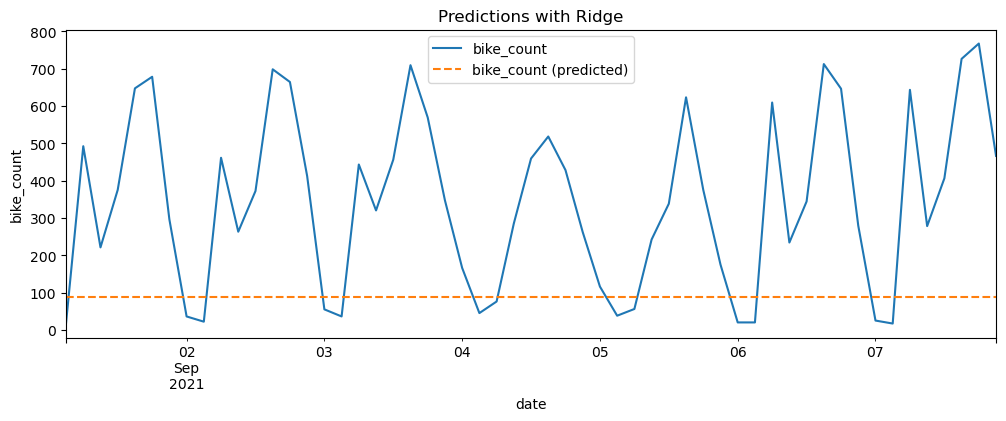

In [99]:
fig, ax = plt.subplots(figsize=(12, 4))

df_viz.plot(x="date", y="bike_count", ax=ax)
df_viz.plot(x="date", y="bike_count (predicted)", ax=ax, ls="--")
ax.set_title("Predictions with Ridge")
ax.set_ylabel("bike_count")

So we start to see the daily trend, and some of the week day differences are accounted for, however we still miss the details and the spikes in the evening are under-estimated.

A useful way to visualize the error is to plot `y_pred` as a function of `y_true`,

<Axes: xlabel='y_true', ylabel='y_pred'>

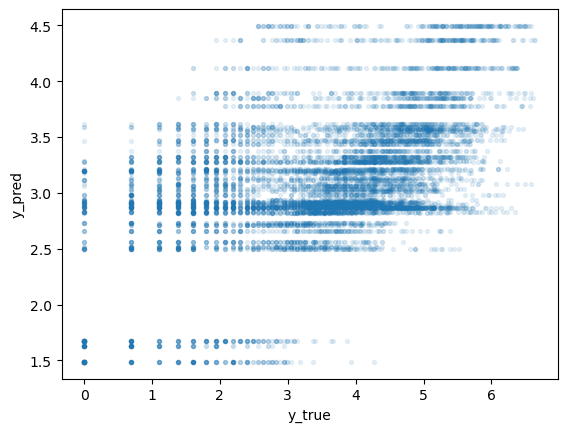

In [100]:
fig, ax = plt.subplots()

df_viz = pd.DataFrame({"y_true": y_valid, "y_pred": pipe.predict(X_valid)}).sample(
    10000, random_state=0
)

df_viz.plot.scatter(x="y_true", y="y_pred", s=8, alpha=0.1, ax=ax)

It is recommended to use cross-validation for hyper-parameter tuning with [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) or more reliable model evaluation with [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score). In this case, because we want the test data to always be in the future as compared to the train data, we can use [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html):

<img src="https://i.stack.imgur.com/Q37Bn.png" />

The disadvantage, is that we can either have the training set size be different for each fold which is not ideal for hyper-parameter tuning (current figure), or have constant sized small training set which is also not ideal given the data periodicity. This explains that generally we will have worse cross-validation scores than test scores:

In [101]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

cv = TimeSeriesSplit(n_splits=6)

# When using a scorer in scikit-learn it always needs to be better when smaller, hence the minus sign.
scores = cross_val_score(
    pipe, X_train, y_train, cv=cv, scoring="neg_root_mean_squared_error"
)
print("RMSE: ", scores)
print(f"RMSE (all folds): {-scores.mean():.3} ± {(-scores).std():.3}")

RMSE:  [-1.68537329 -1.66138233 -1.62908722 -1.6344636  -1.6263621  -1.32763114]
RMSE (all folds): 1.59 ± 0.121


In [102]:
X_valid = pd.read_parquet(Path("data") / "final_test.parquet")
data.head()

,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,coordinates,counter_technical_id,latitude,longitude,log_bike_count
48321,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 02:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.000000
48324,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,1.0,2020-09-01 03:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.693147
48327,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 04:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.000000
48330,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,4.0,2020-09-01 15:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,1.609438
48333,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,9.0,2020-09-01 18:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,2.302585


In [103]:
y_pred = pipe.predict(X_valid)

results = pd.DataFrame(
    dict(
        Id=np.arange(y_pred.shape[0]),
        log_bike_count=y_pred,
    )
)
results.to_csv("submission.csv", index=False)


### TODO :
Refaire le preprocessing de data meteo ultra propre pour pouvoir l'ajouter facilement à X_valid
et pouvoir tester avec la data en plus.

## Ridge with RFE ()

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import RFE
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# Encodeur pour les dates
date_encoder = FunctionTransformer(_encode_dates)
date_cols = _encode_dates(X_train[["date"]]).columns.tolist()

# Colonnes catégorielles et numériques
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = numerical_columns  # Définies dans ton contexte

# Encodage
numerical_encoder = StandardScaler()
categorical_encoder = OneHotEncoder(handle_unknown="ignore")

# Préprocessing
preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("cat", make_pipeline(categorical_encoder), categorical_cols),
        ("num", make_pipeline(numerical_encoder), numerical_cols),
    ]
)

# Modèle de régression Ridge
ridge = Ridge(alpha=1.0)

# RFE pour la sélection de caractéristiques
n_features_to_select = 10  # Ajuste selon tes besoins
rfe = RFE(estimator=ridge, n_features_to_select=n_features_to_select)

# Pipeline
pipe = make_pipeline(date_encoder, preprocessor, rfe, ridge)

# Entraînement
pipe.fit(X_train, y_train)

# Évaluation
score = pipe.score(X_valid, y_valid)
print(f"Score du modèle Ridge après RFE : {score:.4f}")


In [ ]:
# We do a grid search to find the best alpha ! 
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

# Définir la plage de valeurs pour alpha
param_grid = {'ridge__alpha': [0.01, 0.1, 1, 10, 100]}

# Définir le modèle et la recherche de grille
grid_search = GridSearchCV(pipe, param_grid, cv=5)

# Entraîner le modèle
grid_search.fit(X_train, y_train)

# Afficher le meilleur alpha
print(f"Meilleur alpha: {grid_search.best_params_}")


In [ ]:
best_alpha = grid_search.best_params_['ridge__alpha']
regressor = Ridge(alpha=best_alpha)
pipe = make_pipeline(date_encoder, preprocessor, rfe, ridge)
pipe.fit(X_train, y_train)


We then evaluate this model with the RMSE metric,

In [ ]:
from sklearn.metrics import mean_squared_error

print(
    f"Train set, RMSE={mean_squared_error(y_train, pipe.predict(X_train), squared=False):.2f}"
)
print(
    f"Valid set, RMSE={mean_squared_error(y_valid, pipe.predict(X_valid), squared=False):.2f}"
)

In [ ]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

cv = TimeSeriesSplit(n_splits=6)

# When using a scorer in scikit-learn it always needs to be better when smaller, hence the minus sign.
scores = cross_val_score(
    pipe, X_train, y_train, cv=cv, scoring="neg_root_mean_squared_error"
)
print("RMSE: ", scores)
print(f"RMSE (all folds): {-scores.mean():.3} ± {(-scores).std():.3}")

In [ ]:
y_pred = pipe.predict(X_valid)

results = pd.DataFrame(
    dict(
        Id=np.arange(y_pred.shape[0]),
        log_bike_count=y_pred,
    )
)
results.to_csv("submission.csv", index=False)


# Regression With Lasso

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import RFE
from sklearn.linear_model import Lasso
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# Encodeur pour les dates
date_encoder = FunctionTransformer(_encode_dates)
date_cols = _encode_dates(X_train[["date"]]).columns.tolist()

# Colonnes catégorielles et numériques
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = numerical_columns  # Définies dans ton contexte

# Encodage
numerical_encoder = StandardScaler()
categorical_encoder = OneHotEncoder(handle_unknown="ignore")

# Préprocessing
preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("cat", make_pipeline(categorical_encoder), categorical_cols),
        ("num", make_pipeline(numerical_encoder), numerical_cols),
    ]
)

# Modèle de régression Lasso
lasso = Lasso(alpha=1.0)

# RFE pour la sélection de caractéristiques
n_features_to_select = 10  # Ajuste selon tes besoins
rfe = RFE(estimator=lasso, n_features_to_select=n_features_to_select)

# Pipeline
pipe = make_pipeline(date_encoder, preprocessor, rfe, lasso)

# Entraînement
pipe.fit(X_train, y_train)

# Évaluation
score = pipe.score(X_valid, y_valid)
print(f"Score du modèle Lasso après RFE : {score:.4f}")


In [ ]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

cv = TimeSeriesSplit(n_splits=6)

# When using a scorer in scikit-learn it always needs to be better when smaller, hence the minus sign.
scores = cross_val_score(
    pipe, X_train, y_train, cv=cv, scoring="neg_root_mean_squared_error"
)
print("RMSE: ", scores)
print(f"RMSE (all folds): {-scores.mean():.3} ± {(-scores).std():.3}")

### Ok : nul à chier 

# Regression with ElasticNet

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import RFE
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# Encodeur pour les dates
date_encoder = FunctionTransformer(_encode_dates)
date_cols = _encode_dates(X_train[["date"]]).columns.tolist()

# Colonnes catégorielles et numériques
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = numerical_columns  # Définies dans ton contexte

# Encodage
numerical_encoder = StandardScaler()
categorical_encoder = OneHotEncoder(handle_unknown="ignore")

# Préprocessing
preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("cat", make_pipeline(categorical_encoder), categorical_cols),
        ("num", make_pipeline(numerical_encoder), numerical_cols),
    ]
)

# Modèle de régression ElasticNet
elasticnet = ElasticNet(alpha=1.0, l1_ratio=0.5)  # alpha contrôle la régularisation, l1_ratio ajuste la proportion L1/L2

# RFE pour la sélection de caractéristiques
n_features_to_select = 10  # Ajuste selon tes besoins
rfe = RFE(estimator=elasticnet, n_features_to_select=n_features_to_select)

# Pipeline
pipe = make_pipeline(date_encoder, preprocessor, rfe, elasticnet)

# Entraînement
pipe.fit(X_train, y_train)

# Évaluation
score = pipe.score(X_valid, y_valid)
print(f"Score du modèle ElasticNet après RFE : {score:.4f}")


In [ ]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

cv = TimeSeriesSplit(n_splits=6)

# When using a scorer in scikit-learn it always needs to be better when smaller, hence the minus sign.
scores = cross_val_score(
    pipe, X_train, y_train, cv=cv, scoring="neg_root_mean_squared_error"
)
print("RMSE: ", scores)
print(f"RMSE (all folds): {-scores.mean():.3} ± {(-scores).std():.3}")

### nul à chier

# DecisionTreeRegressor

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Modèle avec des paramètres ajustés
tree_regressor = DecisionTreeRegressor(
    max_depth=5,  # Limite la profondeur de l'arbre
    min_samples_split=10,  # Nécessite plus d'échantillons pour diviser un nœud
    min_samples_leaf=5,  # Nécessite plus d'échantillons dans chaque feuille
    max_features="sqrt",  # Utilise un sous-ensemble des features à chaque division
    random_state=42  # Pour reproductibilité
)

# Pipeline de préprocessing (on suppose que les variables X_train et y_train sont déjà définies)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_cols),  # Standardisation des variables numériques
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)  # Encodage des variables catégorielles
    ]
)

pipe = make_pipeline(preprocessor, tree_regressor)

# Entraînement du modèle
pipe.fit(X_train, y_train)

# Évaluation
score = pipe.score(X_valid, y_valid)
print(f"Score du modèle DecisionTreeRegressor : {score:.4f}")


In [ ]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

cv = TimeSeriesSplit(n_splits=6)

# When using a scorer in scikit-learn it always needs to be better when smaller, hence the minus sign.
scores = cross_val_score(
    pipe, X_train, y_train, cv=cv, scoring="neg_root_mean_squared_error"
)
print("RMSE: ", scores)
print(f"RMSE (all folds): {-scores.mean():.3} ± {(-scores).std():.3}")

### nul à chier

# GRRRRRRADIENT BOOOOOOOSTING

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Modèle GradientBoostingRegressor
gbr = GradientBoostingRegressor(
    n_estimators=100,  # Nombre d'arbres
    learning_rate=0.1,  # Taux d'apprentissage
    max_depth=3,  # Profondeur des arbres
    random_state=42  # Pour la reproductibilité
)

# Pipeline de préprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_cols),  # Standardisation des variables numériques
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)  # Encodage des variables catégorielles
    ]
)

# Pipeline complet
pipe = make_pipeline(preprocessor, gbr)

# Entraînement du modèle
pipe.fit(X_train, y_train)

# Évaluation
score = pipe.score(X_valid, y_valid)
print(f"Score du modèle GradientBoostingRegressor : {score:.4f}")


In [ ]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

cv = TimeSeriesSplit(n_splits=6)

# When using a scorer in scikit-learn it always needs to be better when smaller, hence the minus sign.
scores = cross_val_score(
    pipe, X_train, y_train, cv=cv, scoring="neg_root_mean_squared_error"
)
print("RMSE: ", scores)
print(f"RMSE (all folds): {-scores.mean():.3} ± {(-scores).std():.3}")

# XGBOOST ?

In [106]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [111]:
import xgboost as xgb
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Modèle XGBoostRegressor
xgboost = xgb.XGBRegressor(
    n_estimators=100,  # Nombre d'arbres
    learning_rate=0.1,  # Taux d'apprentissage
    max_depth=3,  # Profondeur des arbres
    random_state=42,  # Pour la reproductibilité
    objective='reg:squarederror'  # Fonction de perte pour la régression
)

# Pipeline de préprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_cols),  # Standardisation des variables numériques
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)  # Encodage des variables catégorielles
    ]
)

# Pipeline complet
pipe = make_pipeline(preprocessor, xgboost)

# Entraînement du modèle
pipe.fit(X_train, y_train)

# Évaluation
score = pipe.score(X_valid, y_valid)
print(f"Score du modèle XGBoostRegressor : {score:.4f}")


Score du modèle XGBoostRegressor : 0.1329


In [112]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

cv = TimeSeriesSplit(n_splits=6)

# When using a scorer in scikit-learn it always needs to be better when smaller, hence the minus sign.
scores = cross_val_score(
    pipe, X_train, y_train, cv=cv, scoring="neg_root_mean_squared_error"
)
print("RMSE: ", scores)
print(f"RMSE (all folds): {-scores.mean():.3} ± {(-scores).std():.3}")

RMSE:  [-1.6853648  -1.6616736  -1.62917935 -1.63435753 -1.62666959 -1.32790012]
RMSE (all folds): 1.59 ± 0.121


In [113]:
y_pred = pipe.predict(X_valid)

results = pd.DataFrame(
    dict(
        Id=np.arange(y_pred.shape[0]),
        log_bike_count=y_pred,
    )
)
results.to_csv("submission.csv", index=False)


In [114]:
results.shape

(13314, 2)